# Introduction to NetworkX
Networkx is a package that lets you configure, build and analyze complex networks. 

In [145]:
import os, re, sys
import ast

import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np 
import networkx as nx 
import kmeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


Dataset we are using is the MovieMetadata via kaggle: [Here](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv)

**Filter down our feature set**

In [146]:
cols = ['budget','original_language', 'original_title',
       'production_companies',
        'release_date', 
        'title',
       'genres', 'vote_average'
       ]
df = pd.read_csv('movies_metadata.csv', low_memory=False)[cols]
df=df.loc[df['original_language'] == 'en'].reset_index(drop=True)
df = df.fillna(-999)

In [147]:
df['date'] = pd.to_datetime(df['release_date'])
df['year'] = df['date'].dt.year

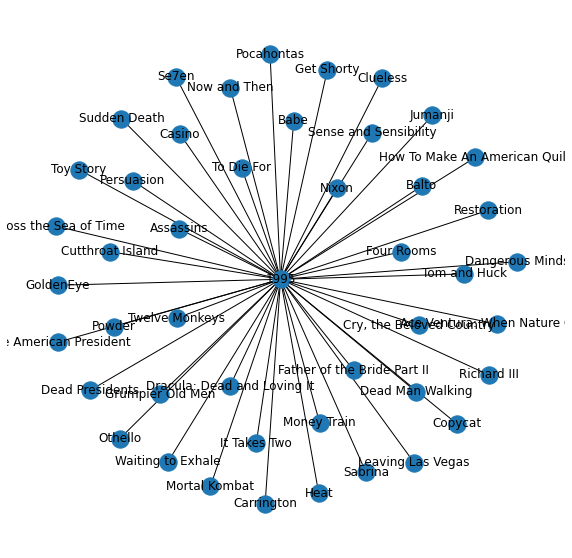

In [148]:
G = nx.from_pandas_edgelist(df[:45], source='title', target='year')
fig,axs = plt.subplots(1,1,figsize=(10,10))
nx.draw(G, with_labels=True)

In [149]:
def get_contents(l): 
    try: 
        dicts = ast.literal_eval(l)
        return [x['name'] for x in dicts if 'name' in x]
    except: 
        return '[]'
df['production_companies_list'] = df['production_companies'].apply(get_contents)
df['genre_list'] = df['genres'].apply(get_genres)


# Recommender

In [150]:
genre_list = list()
for row in range(len(df)): 
    [genre_list.append(x) for x in df['genre_list'][row] if x not in genre_list]
print(genre_list)

['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Music', 'Documentary', 'Foreign', 'Western', 'TV Movie']


In [151]:
for genre in genre_list: 
    df[genre] = 0

In [152]:
for row in range(len(df)): 
    genres = df['genre_list'][row]
    for genre in genres: 
        if genre in genre_list: 
            df[genre][row] = 1
    

/var/folders/md/c9lgr11n7x1c0_tghtfh_kjr0000gn/T/ipykernel_35864/668341851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[genre][row] = 1


In [153]:
pca = PCA(n_components=2)

In [154]:
reduction = pca.fit_transform(X=df[genre_list + ['vote_average']].values)
reduction = pd.DataFrame(reduction)
df['x'] = reduction[0]
df['y'] = reduction[1]

In [155]:
df[['title','x','y']]

,title,x,y
0,Toy Story,-2.271873,-0.827712
1,Jumanji,-1.471023,-0.411244
2,Grumpier Old Men,-1.071643,-0.596705
3,Waiting to Exhale,-0.673154,0.234395
4,Father of the Bride Part II,-0.271110,-0.685615
...,...,...,...
32264,Caged Heat 3000,1.930371,-0.309156
32265,Robin Hood,-0.271431,0.699507
32266,Betrayal,1.629364,0.836558
32267,Satan Triumphant,5.429679,-0.256423


<AxesSubplot:xlabel='x', ylabel='y'>

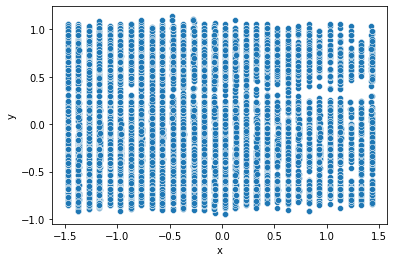

In [157]:
df = df.loc[((df['x'] <= 1.5) & (df['x'] >= -1.5))]
sns.scatterplot(data=df, x='x',y='y')

In [158]:
df['production_company'] = df['production_companies_list'].str[0]
master = df[['title','x','y','year', 'production_company']].copy()
master = master.loc[master['year'].fillna(0).astype('int') > 1800].copy()

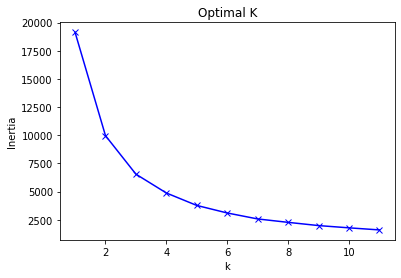

In [159]:
distances = []
K = range(1,12)
for k in K: 
    km = KMeans(n_clusters=k).fit(master[['x','y']])
    distances.append(km.inertia_)

plt.plot(K, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Optimal K')
plt.show()

Optimal clusters = 4

<AxesSubplot:xlabel='x', ylabel='y'>

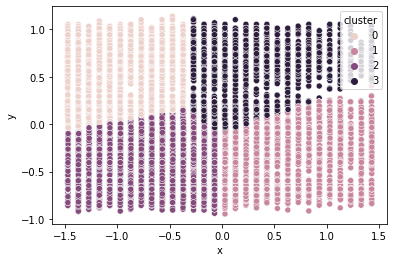

In [160]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(master[['x','y']])
master['cluster'] = kmeans.labels_
sns.scatterplot(x=master['x'], y=master['y'], hue=master['cluster'])

In [161]:
master = master.loc[~master['production_company'].isna()].reset_index(drop=True)

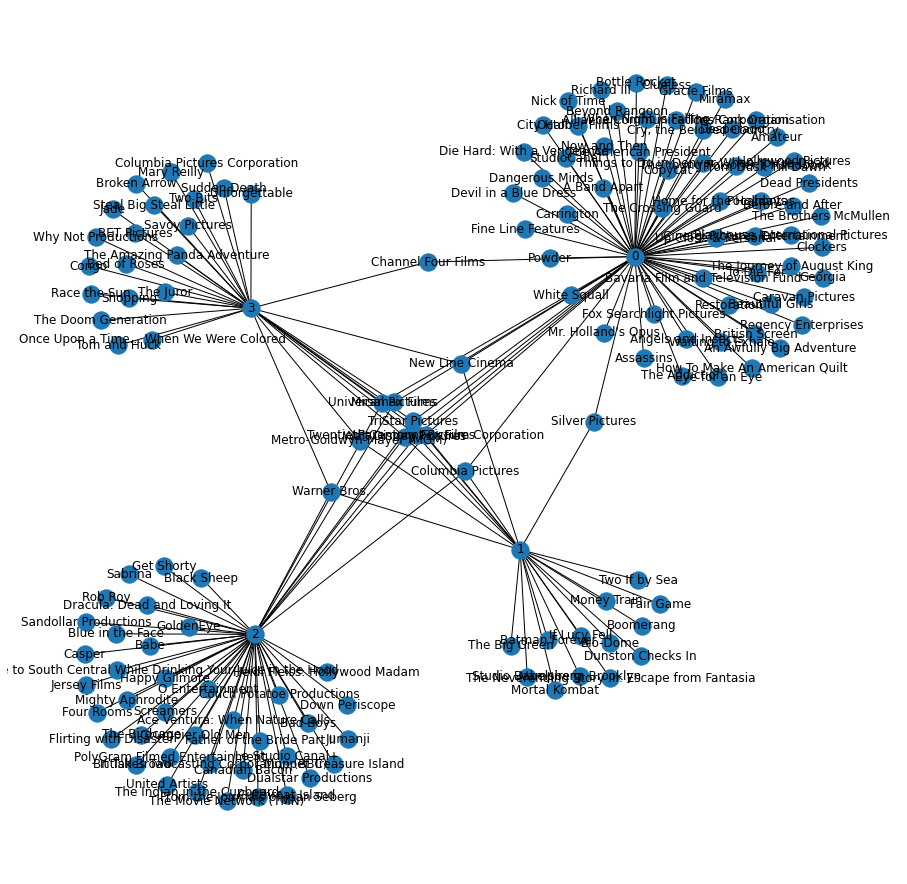

In [162]:
links = list(zip(master['cluster'], master['production_company']))[:100]
fig,axs = plt.subplots(1,1,figsize=(16,16))
G = nx.from_pandas_edgelist(master[:100], source='cluster', target='title')
G.add_edges_from(links,)
nx.draw(G, with_labels=True,)
